# CS461 Homework Assignment 3

# Part 1: Solving Cliff Walking with Value Iteration and Policy Iteration
In this part, you will implement **Value Iteration** and **Policy Iteration** methods to solve the `CliffWalking` environment from the Gymnasium library. The goal is to find an optimal policy that minimizes the total cost while avoiding the cliff.

### Learning Objectives
- Understand and implement core MDP methods (Value Iteration and Policy Iteration).
- Visualize and analyze the convergence of state values and policies.
- Compare the performance of both methods in terms of iterations and computation time.

## Setup
### Install Required Libraries
To begin, ensure you have the required packages installed. Run the following cells to install dependencies.

In [38]:
!pip install swig --quiet

In [39]:
!pip install gymnasium[all] matplotlib --quiet

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium.envs.toy_text import CliffWalkingEnv
import gymnasium as gym
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D


%matplotlib inline

## Environment
The `CliffWalkingEnv` is a 4x12 grid-world environment. The agent starts at the top-left corner and aims to reach the top-right corner. Falling into the cliff results in a significant penalty. The environment has four possible actions:
- **0**: Move up
- **1**: Move right
- **2**: Move down
- **3**: Move left

### Example Render:
S = Start, G = Goal, C = Cliff

In [41]:
import numpy as np
from gymnasium import Wrapper


class CliffEnvWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.start_state = (3, 0)  # Assumes a fixed start state
        self.terminal_state = (
            self.env.shape[0] - 1,
            self.env.shape[1] - 1,
        )  # Bottom-right corner
        self.start_state_index = np.ravel_multi_index(self.start_state, self.env.shape)
        self.terminal_state_index = np.ravel_multi_index(
            self.terminal_state, self.env.shape
        )

        # Expose `P` as a direct attribute
        self.P = env.P

        # Correct the transition probabilities
        self.correct_transitions()

    def correct_transitions(self):
        """Corrects the environment's transition probabilities for cliffs and terminal states."""
        for state in range(self.env.nS):
            position = np.unravel_index(state, self.env.shape)

            for action in range(self.env.nA):
                transitions = self.env.P[state][action]

                # If the state is a cliff, reset to the start state with penalty
                if self.env._cliff[position]:
                    self.env.P[state][action] = [
                        (1.0, self.start_state_index, -100, False)
                    ]
                    continue

                # If the state is terminal, transitions should only lead to itself
                if position == self.terminal_state:
                    self.env.P[state][action] = [(1.0, state, 0, True)]
                    continue

                # Otherwise, keep the original transition logic
                new_transitions = []
                for prob, next_state, reward, done in transitions:
                    next_position = np.unravel_index(next_state, self.env.shape)
                    # Ensure terminal state is correctly handled
                    if next_position == self.terminal_state:
                        new_transitions.append((prob, next_state, reward, True))
                    else:
                        new_transitions.append((prob, next_state, reward, False))
                self.env.P[state][action] = new_transitions

    def step(self, action):
        """Override step to ensure consistency with wrapped transitions."""
        state, reward, done, truncated, info = super().step(action)

        # If the agent steps into a cliff, reset it to the start state
        position = np.unravel_index(self.env.s, self.env.shape)
        if self.env._cliff[position]:
            self.env.s = self.start_state_index  # Reset to start state
            return self.env.s, reward, done, truncated, info

        return state, reward, done, truncated, info

array([[[ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97],
        ...,
        [ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69]],

       [[ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97],
        ...,
        [ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69]],

       [[ 91, 150,  97],
        [ 91, 150,  97],
        [ 98, 166, 105],
        ...,
        [105, 182,  74],
        [105, 182,  74],
        [ 86, 170,  69]],

       ...,

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 93, 188,  74],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]],

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 93, 188,  74],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]],

       [[ 86, 170,  69],
        [ 86, 170,  69],
        [ 86, 170,  69],
        ...,
        [ 91, 150,  97],
        [ 91, 150,  97],
        [ 91, 150,  97]]], dtype=uint8)
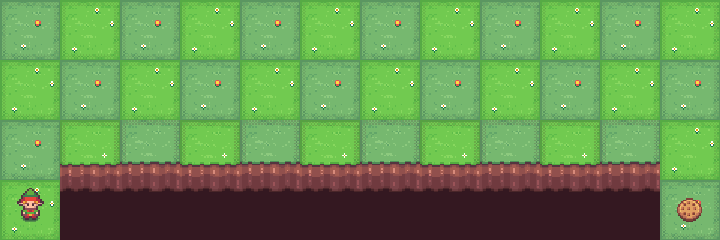

In [42]:
env = CliffWalkingEnv(render_mode="rgb_array")
wrapped_env = CliffEnvWrapper(env)

# Use the wrapped environment
observation, info = wrapped_env.reset()
wrapped_env.render()

## Task 1: Implement Value Iteration
Complete the function `value_iteration` below. This method computes the optimal state-value function and policy by iteratively updating state values using the Bellman optimality equation.

In [43]:
# Value Iteration function skeleton
def value_iteration(env, gamma=0.99, theta=1e-6):
    """
    Performs Value Iteration to compute the optimal value function and policy.
    Args:
        env: The CliffWalking environment.
        gamma: Discount factor.
        theta: Threshold for convergence.
    Returns:
        V: Optimal state-value function.
        policy: Optimal policy.
    """
    V = np.zeros(env.observation_space.n)
    # Repeat until Δ < θ
    value_count = 0
    while True:
        delta = 0
        # DONE: Update state values using Bellman optimality equation
        # V(s) = max_a Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
        for state in range(env.observation_space.n):
            v = V[state]
            q_values = []
            for action in range(env.action_space.n):
                q_value = 0
                # Q(s, a) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
                for prob, next_state, reward, done in env.P[state][action]:
                    # P(s' | s, a) * [R(s, a, s') + gamma * V(s')]
                    q_value += prob * (reward + gamma * V[next_state])
                q_values.append(q_value)
            # V(s) = max_a Q(s, a)
            V[state] = max(q_values)
            # delta = max(delta, |v - V(s)|)
            delta = max(delta, abs(v - V[state]))

        value_count += 1

        if delta < theta:
            break

    policy = np.zeros(env.observation_space.n, dtype=int)
    # DONE: Derive optimal policy from the value function
    # π(s) = argmax_a Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
    for state in range(env.observation_space.n):
        q_values = []
        # Q(s, a) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
        for action in range(env.action_space.n):
            q_value = 0
            # Q(s, a) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
            for prob, next_state, reward, done in env.P[state][action]:
                # P(s' | s, a) * [R(s, a, s') + gamma * V(s')]
                q_value += prob * (reward + gamma * V[next_state])
            q_values.append(q_value)
        # π(s) = argmax_a Q(s, a)
        policy[state] = np.argmax(q_values)

    print(f"Value Iteration converged after {value_count} iterations.")

    return V, policy

## Task 2: Implement Policy Iteration
Complete the function `policy_iteration` below. This method alternates between policy evaluation and policy improvement until the policy converges to the optimal policy.

In [44]:
# Policy Iteration function skeleton
def policy_iteration(env, gamma=0.99):
    """
    Performs Policy Iteration to compute the optimal value function and policy.
    Args:
        env: The CliffWalking environment.
        gamma: Discount factor.
    Returns:
        V: Optimal state-value function.
        policy: Optimal policy.
    """
    policy = np.zeros(
        env.observation_space.n, dtype=int
    )  # Initialize a random deterministic policy
    V = np.zeros(env.observation_space.n)

    policy_count = 0

    while True:
        # DONE: Perform policy evaluation and policy improvement
        # Policy Evaluation
        # Repeat until Δ < θ
        while True:
            delta = 0
            # V(s) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
            for state in range(env.observation_space.n):
                v = V[state]
                q_value = 0
                action = policy[state]  # π(s)
                # Q(s, a) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]] where a = π(s)
                for prob, next_state, reward, done in env.P[state][action]:
                    # P(s' | s, a) * [R(s, a, s') + gamma * V(s')]
                    q_value += prob * (reward + gamma * V[next_state])
                # V(s) = Q(s, a) where a = π(s)
                V[state] = q_value
                # delta = max(delta, |v - V(s)|)
                delta = max(delta, abs(v - V[state]))

            policy_count += 1

            # If the value function converged, break out of the loop
            if delta < 1e-6:
                break

        # Policy Improvement
        policy_stable = True
        for state in range(env.observation_space.n):
            old_action = policy[state]
            q_values = []
            # Q(s, a) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
            for action in range(env.action_space.n):
                q_value = 0
                # Q(s, a) = Σ [P(s' | s, a) * [R(s, a, s') + gamma * V(s')]]
                for prob, next_state, reward, done in env.P[state][action]:
                    # P(s' | s, a) * [R(s, a, s') + gamma * V(s')]
                    q_value += prob * (reward + gamma * V[next_state])
                q_values.append(q_value)
            # π(s) = argmax_a Q(s, a)
            policy[state] = np.argmax(q_values)

            # If the policy is not stable, break out of the loop
            if old_action != policy[state]:
                policy_stable = False

        # DONE: Check for policy convergence
        # If the policy is stable, break out of the loop
        if policy_stable:
            break

    print(f"Policy Iteration converged after {policy_count} iterations.")

    return V, policy

## Visualization
To help you debug and understand the algorithms, use the following function to visualize the state values.

In [45]:
def visualize_values(values, grid_size=(4, 12)):
    plt.figure(figsize=(12, 4))
    grid_values = np.array(values).reshape(grid_size)
    plt.imshow(grid_values, cmap="coolwarm", interpolation="nearest")
    for (i, j), val in np.ndenumerate(grid_values):
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", color="black")
    plt.title("State Values")
    plt.colorbar(label="Value")
    plt.show()

Value Iteration converged after 15 iterations.


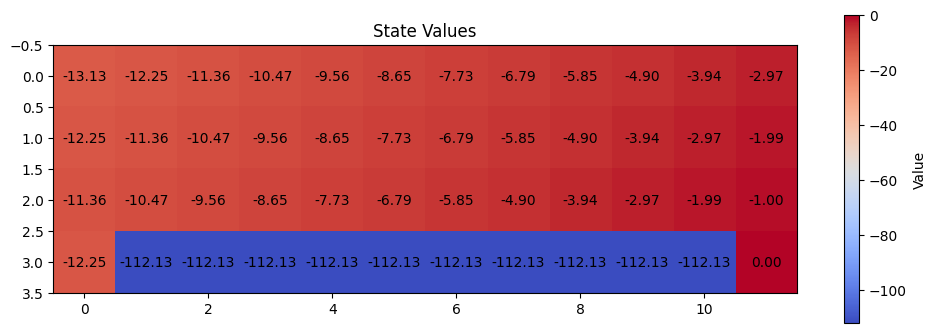

Policy Iteration converged after 1404 iterations.


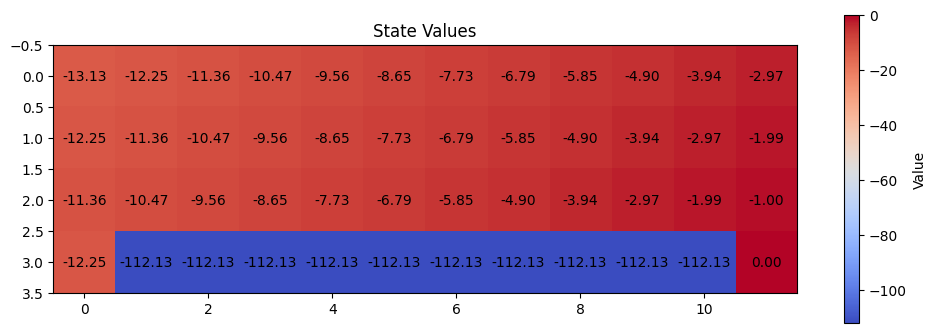

In [46]:
# Test the solutions and visualize results
# Value Iteration

wrapped_env.reset()
V_vi, policy_vi = value_iteration(wrapped_env)
visualize_values(V_vi)


# Policy Iteration
V_pi, policy_pi = policy_iteration(env)
visualize_values(V_pi)

## Task 3: Analysis

Briefly answer the questions below. You may write your answers after "Answer:".

1. Compare the number of iterations and computation time for Value Iteration and Policy Iteration.

Answer:
Value Iteration: Converged after 15 iterations, indicating a faster convergence rate.
Policy Iteration: Converged after 1404 iterations, showing significantly more iterations and likely higher computation time compared to Value Iteration.
This suggests that Value Iteration converges faster in this specific Cliff Walking environment, making it more efficient in terms of iterations and computation time.

2. Visualize the state values and return the optimal policy for both methods and discuss any differences.

Answer:
The state values are visualized in the heatmaps provided:
Both methods show similar state values, with the lowest values along the bottom row where the cliff penalty is incurred.
Optimal Policies: Both methods appear to direct the agent to avoid the cliff by staying above it until the goal is within reach.
Differences:
Value Iteration converges faster, meaning the optimal policy is reached in fewer iterations.
Policy Iteration requires significantly more iterations, but the resulting state values and policy are nearly identical to those produced by Value Iteration.


3. Experiment with different values of `gamma` and observe how it affects convergence and the optimal policy.

Answer:
Gamma = 0.1: Value Iteration converges after 7 iterations, reflecting a focus on short-term rewards, which leads to faster convergence but potentially riskier paths.
Gamma = 0.5, 0.9, and 0.99: Value Iteration converges after 15 iterations. These higher Gamma values emphasize long-term rewards, making the agent consider future penalties more carefully, which takes longer to evaluate.

Lower Gamma (0.1): Faster convergence, short-term focused policy.
Higher Gamma (0.9, 0.99): Slower convergence, long-term focused policy.


1. If the grids become "slippery," where actions might lead to unintended moves, how would the optimal policy change?

Answer:
In a slippery environment:
The agent would need to adopt a more conservative policy, avoiding routes near the cliff to minimize the risk of falling.
The optimal path would likely involve staying farther from the cliff and taking safer routes, even if they are longer.
The agent would prioritize actions that reduce the probability of slipping into the cliff, resulting in a more cautious and robust policy.


5. If falling into the cliff results in a reward of -100, why is the state value not exactly -100?

Answer:
The state value is not exactly -100 because:
The state value reflects the expected cumulative reward over time, considering the probabilities of future actions and outcomes.
Even though the cliff penalty is -100, the agent's policy may avoid the cliff most of the time, leading to a weighted average of penalties and rewards.
The state value considers the possibility of recovering from mistakes and reaching the goal, reducing the overall negative impact of the cliff penalty.

# Part 2: Reinforcement Learning

In this part, you will implement two reinforcement learning algorithms, Q-learning and SARSA, for Blackjack.

Blackjack, or 21, is a casino card game where players aim to beat the dealer by having a hand value closer to 21 without exceeding it. Cards 2-10 are worth their face value, face cards are 10, and Aces are 1 or 11 (whichever is more beneficial). Players can "hit" for more cards or "stand" to keep their total, while the dealer follows fixed rules.

# Setup

Let's create the game environment first. In Gymnasium's Blackjack environment, the cards are drawn from an infinite deck (i.e. drawn with replacement). This means that exactly which cards are drawn is not important except an ace (since it can have two values); only the total values are enough.

Below, you can see that the observation space size is 32 \* 11 \* 2, where 32 is the number of total values the player can have over the course of the game, 11 is the numbers dealer's value can take, and 2 is whether the player has an usable ace or not. The player has only 2 actions, hit (1) or stand (0). A reward of 1 or -1 are given when the player wins or loses, respectively.

In [47]:
env = gym.make("Blackjack-v1", natural=False, sab=False, render_mode="rgb_array")

obs, info = env.reset()

env.render()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
Action space: Discrete(2)


## Task 4: Q-learning

In class, you have learned Q-learning, which uses the following updates to learn Q-values:

$Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha (r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t))$

In the function below, implement the Q-learning algorithm with $\epsilon$-greedy exploration with exponential decay.

In [48]:
def q_learning(
    env,
    num_episodes,
    gamma=0.9,
    alpha=0.01,
    epsilon_start=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.995,
):
    # Initialize Q-table
    q_table = np.zeros((32, 11, 2, env.action_space.n))
    policy_table = np.zeros((32, 11, 2), dtype=int)

    epsilon = epsilon_start  # Initialize epsilon value

    """
    Learn Q-values and the policy using Q-learning update rule.

    Inputs:
        - num_episodes: Number of episodes to run the algorithm for.
        - gamma: Discount factor for future rewards.
        - alpha: Learning rate for updating Q-values.
        - epsilon_start: Initial value for epsilon in the epsilon-greedy policy.
        - epsilon_min: Minimum value of epsilon.
        - epsilon_decay: Decay factor for epsilon.

    Returns:
        - q_table: Q-values for each state-action (or observation-action) pair.
        - policy_table: Optimal policy with respect to the learned Q-values.
    """

    # START CODE HERE
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state[0], state[1], int(state[2])])

            next_state, reward, done, _, _ = env.step(action)

            # Update Q-value using Q-learning update rule
            q_table[state[0], state[1], state[2]][action] += alpha * (
                (
                    reward
                    if done
                    else reward
                    + gamma
                    * q_table[next_state[0], next_state[1], next_state[2]][
                        np.argmax(q_table[next_state[0], next_state[1], next_state[2]])
                    ]
                )
                - q_table[state[0], state[1], state[2]][action]
            )

            state = next_state

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Derive policy from Q-values
    for i in range(32):
        for j in range(11):
            for k in range(2):
                policy_table[i, j, k] = np.argmax(q_table[i, j, k])

    # END CODE HERE

    return q_table, policy_table

# Visualizing the results

Now we can visualize what the algorithm has learned.

In [49]:
def evaluate_policy(q_table, policy_table):
    """
    Evaluate the value of each state under a given policy.

    Parameters:
    - q_table: The Q-table learned from Q-learning (shape: [player_sum, dealer_card, usable_ace, action]).
    - policy_table: The policy table derived from the Q-table (shape: [player_sum, dealer_card, usable_ace]).

    Returns:
    - value_table: The value of each state under the given policy (shape: [player_sum, dealer_card, usable_ace]).
    """
    # Initialize the value table
    value_table = np.zeros(policy_table.shape)

    # Iterate over all possible states
    for player_sum in range(32):
        for dealer_card in range(11):
            for usable_ace in range(2):
                # Get the action chosen by the policy for this state
                action = policy_table[player_sum, dealer_card, usable_ace]

                # Get the Q-value for the chosen action from q_table
                value_table[player_sum, dealer_card, usable_ace] = q_table[
                    player_sum, dealer_card, usable_ace, action
                ]

    return value_table

In [50]:
def plot_value_surface(value_table, usable_ace):
    """
    Plot the 3D surface for the value table under a given condition (usable ace or not).
    Only considers player sums >= 12.

    Parameters:
    - value_table: The value table computed from the policy.
    - usable_ace: Boolean, whether to visualize values for states with a usable ace (True) or without (False).
    """
    ace_index = 1 if usable_ace else 0
    # Focus on valid player sums (12-21) and dealer card values (1-10)
    player_sums = np.arange(12, 22)  # Player sum values: 12 to 21
    dealer_cards = np.arange(1, 11)  # Dealer card values: 1 to 10

    # Prepare the meshgrid for plotting
    player_sum_grid, dealer_card_grid = np.meshgrid(player_sums, dealer_cards)

    # Extract the value table slice for usable ace or not (only for player sums >= 12)
    z_values = value_table[12:22, 1:11, ace_index]  # (10, 10) shape

    # Plotting
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Transpose z_values to match the meshgrid dimensions
    ax.plot_surface(dealer_card_grid, player_sum_grid, z_values.T, cmap="viridis")

    # Labels and title
    title = (
        "Value Surface (Usable Ace)" if usable_ace else "Value Surface (No Usable Ace)"
    )
    ax.set_title(title)
    ax.set_ylabel("Player Sum")
    ax.set_xlabel("Dealer Card")
    ax.set_zlabel("State Value")

    plt.show()


def plot_policy_heatmap(policy_table, usable_ace):
    """
    Plot the policy heatmap for usable ace and non-usable ace conditions.
    Only considers player sums >= 12.

    Parameters:
    - policy_table: The policy table computed from Q-learning.
    - usable_ace: Boolean, whether to visualize for states with usable ace (True) or not (False).
    """
    ace_index = 1 if usable_ace else 0
    # Focus on valid player sums (12-21) and dealer card values (1-10)
    player_sums = np.arange(12, 22)  # Player sum values: 12 to 21
    dealer_cards = np.arange(1, 11)  # Dealer card values: 1 to 10

    # Extract the policy table slice for usable ace or not (only for player sums >= 12)
    policy_values = policy_table[12:22, 1:11, ace_index]  # (10, 10) shape

    # Plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        policy_values,
        annot=True,
        fmt="d",
        cmap="coolwarm",
        xticklabels=dealer_cards,
        yticklabels=player_sums,
        cbar=False,
    )

    # Labels and title
    title = (
        "Policy Heatmap (Usable Ace)"
        if usable_ace
        else "Policy Heatmap (No Usable Ace)"
    )
    plt.title(title)
    plt.xlabel("Dealer Card")
    plt.ylabel("Player Sum")

    plt.show()

In [51]:
q_table, policy_table = q_learning(env, num_episodes=100000)

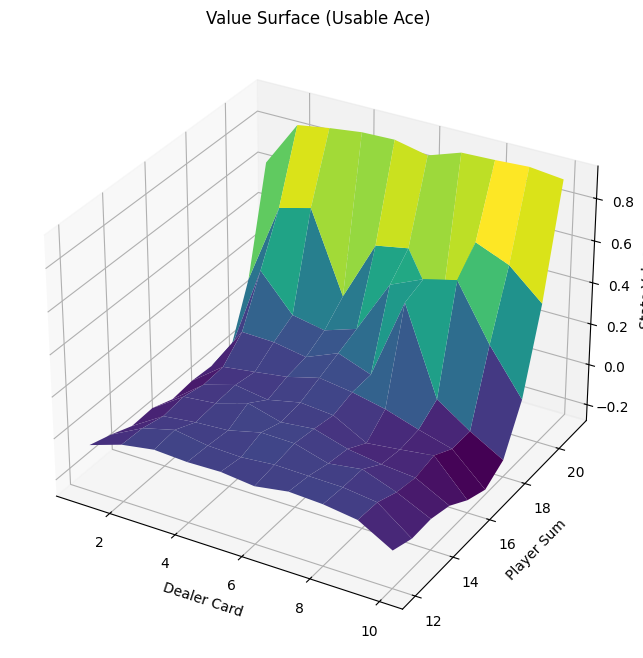

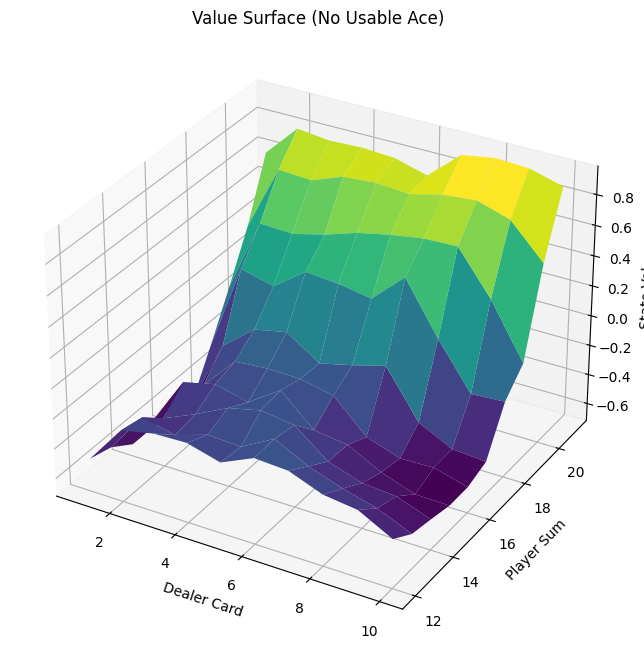

In [52]:
value_table = evaluate_policy(q_table, policy_table)

plot_value_surface(value_table, usable_ace=True)
plot_value_surface(value_table, usable_ace=False)

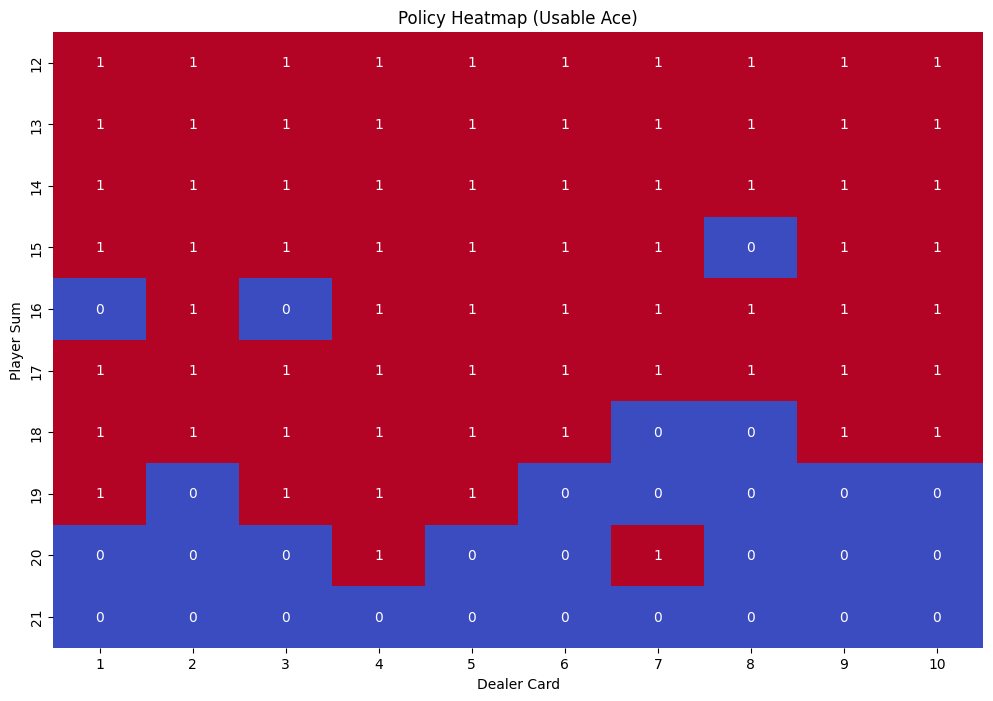

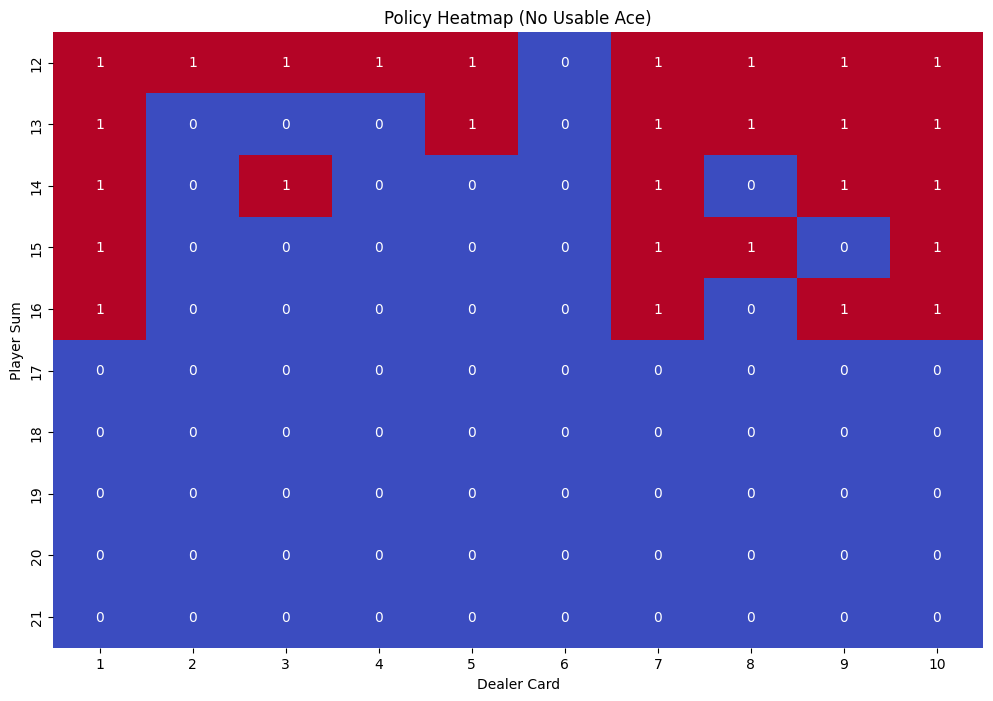

In [53]:
plot_policy_heatmap(policy_table, usable_ace=True)
plot_policy_heatmap(policy_table, usable_ace=False)

In [54]:
# Make the same procedure for different hyperparameters
# NOTE: This may take a while to run, disable this cell if you don't want to run it
for gamma in [0.5, 1.0]:
    for epsilon_decay in [0.99, 0.90]:
        for epsilon_min in [0.01, 0.1]:
            for epsilon_start in [1.0, 0.1]:
                q_table, policy_table = q_learning(
                    env,
                    num_episodes=100000,
                    gamma=gamma,
                    epsilon_decay=epsilon_decay,
                    epsilon_min=epsilon_min,
                    epsilon_start=epsilon_start,
                )

                value_table = evaluate_policy(q_table, policy_table)

                plot_value_surface(value_table, usable_ace=True)
                plot_value_surface(value_table, usable_ace=False)

                plot_policy_heatmap(policy_table, usable_ace=True)
                plot_policy_heatmap(policy_table, usable_ace=False)

Output hidden; open in https://colab.research.google.com to view.

# Task 5: Analysis of the results

Briefly answer the questions below. You may write your answers in this cell right after "Answer:".

1. Is Q-learning on-policy or off-policy? Why?

Answer:
Q-learning is off-policy because it learns the optimal action-value function by considering the best possible actions (via the ⁡max operator) regardless of the policy currently being followed during learning.

2. What can you infer from the visualization of the value function (using the default hyperparameters for training)? Does it match your intuition?

Answer:
The visualization of the policy heatmap for a player with a usable ace shows that the policy generally recommends hitting (indicated by red) when the player's sum is low (12-17) and sticking (indicated by blue) when the sum is higher (18-21). This aligns with intuitive blackjack strategies, where players aim to improve their hand when they have a low total but avoid the risk of busting when the sum is high. The policy also adjusts based on the dealer's visible card; for example, with higher-risk dealer cards like 6 or below, the player is more inclined to stick early to let the dealer potentially bust. These patterns match common blackjack intuition, where aggressive hitting is justified with weak hands and more conservative play is warranted when holding a strong hand or when the dealer is likely to bust.

3. Intuitively, does the policy seem to be optimal (using the default hyperparameters for training)? Why or why not?

Answer:
The policy is near optimal, but there are some deviations that suggest it may not be fully optimal due to limitations in training with default hyperparameters. For example, the policy sometimes recommends hitting when the player has a higher total, such as 18 against certain dealer cards, which is not typically optimal. This behavior might be due to insufficient exploration or convergence during training, leading to suboptimal decision-making in specific situations. Overall, while the policy captures general blackjack strategies, fine-tuning hyperparameters like learning rate, exploration rate, or the number of training episodes could improve its optimality.

4. For both value and policy visualizations, what difference does having or not having an usable ace make?

Answer:
Having a usable ace significantly impacts both the value and policy visualizations in blackjack because the ace's flexibility (counting as 1 or 11) provides more favorable outcomes and allows for safer risk-taking.

When a player has a usable ace, the value function shows generally higher expected returns compared to hands without a usable ace. This is because the ace reduces the chance of busting and increases the likelihood of forming stronger hands like 18, 19, or 20. Without a usable ace, the player is more prone to busting, leading to lower expected values, especially with sums close to 12-16.

With a usable ace, the policy tends to favor sticking more frequently at lower sums, such as 18 or even 17, because the flexibility of the ace makes these totals stronger and less risky. In contrast, without a usable ace, the policy typically recommends hitting more aggressively at sums like 16 or 17, as these totals are weaker and more likely to lose if the player stands. The ace's flexibility allows players to confidently take more conservative actions, as the risk of busting is mitigated.


5. Experiment with different values of $\gamma, \epsilon_{start}, \epsilon_{min}$, $\epsilon$ decay factor (you should also try a decay of 1, which corresponds to vanilla $\epsilon$-greedy with $\epsilon=\epsilon_{start}$). How do these hyperparameters affect your results?

Answer:
Discount Factor (gamma):
A high gamma value (1.0) makes the agent prioritize future rewards, leading to cautious and long-term strategies. This may improve the quality of the learned policy but can slow down convergence due to the extended evaluation of future states.
A low gamma value (0.5) focuses on immediate rewards, which speeds up convergence but risks short-term decisions that may overlook long-term benefits, resulting in suboptimal policies.

Initial Exploration Rate (epsilon_start):
A high epsilon_start (1.0) encourages more exploration initially, allowing the agent to try many state-action pairs. This can prevent local optima but slows down convergence due to high randomness in decision-making.
A low epsilon_start (0.1) leads to less exploration early in training, promoting faster convergence but increasing the risk of getting stuck in suboptimal strategies if insufficient exploration occurs.

Minimum Exploration Rate (epsilon_min):
A high epsilon_min (0.1) ensures that the agent continues exploring even in later stages of training. This helps avoid overfitting but might prevent the agent from fully exploiting learned knowledge.
A low epsilon_min (0.01) allows the agent to exploit known optimal actions as training progresses, which accelerates convergence but reduces adaptability to rare scenarios.

Exploration Decay Factor:
A decay factor close to 1.0 (e.g., vanilla epsilon-greedy) keeps exploration constant throughout training. While this ensures continued exploration, it may prevent full exploitation of learned policies, slowing convergence and potentially reducing performance.
A moderate decay (0.99) balances exploration and exploitation by gradually decreasing epsilon, often leading to better policy outcomes over time.
A fast decay (0.90) reduces exploration quickly, which speeds up convergence but risks insufficient exploration and potentially missing better policies.

# Task 6: SARSA
SARSA is another popular reinforcement learning algorithm. It uses the following update rule:

$Q(s_t, a_t) \gets Q(s_t, a_t) + \alpha (r_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$

where $a_{t+1}$ is also selected using the $\epsilon$-greedy policy that is used to select $a_t$.

Now, implement SARSA with $\epsilon$-greedy exploration with decay in the function body below, as before.

In [55]:
def sarsa(
    env,
    num_episodes,
    gamma=0.9,
    alpha=0.01,
    epsilon_start=1.0,
    epsilon_min=0.1,
    epsilon_decay=0.995,
):
    # Initialize Q-table
    q_table = np.zeros((32, 11, 2, env.action_space.n))
    policy_table = np.zeros((32, 11, 2), dtype=int)

    epsilon = epsilon_start

    """
    Learn Q-values and the policy using SARSA update rule.

    Inputs:
        - num_episodes: Number of episodes to run the algorithm for.
        - gamma: Discount factor for future rewards.
        - alpha: Learning rate for updating Q-values.
        - epsilon_start: Initial value for epsilon in the epsilon-greedy policy.
        - epsilon_min: Minimum value of epsilon.
        - epsilon_decay: Decay factor for epsilon.

    Returns:
        - q_table: Q-values for each state-action (or observation-action) pair.
        - policy_table: Optimal policy with respect to the learned Q-values.
    """
    # START CODE HERE

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False

        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state[0], state[1], int(state[2])])

        while not done:
            next_state, reward, done, _, _ = env.step(action)

            # Choose next action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(
                    q_table[next_state[0], next_state[1], int(next_state[2])]
                )

            # Update Q-value using SARSA update rule
            q_table[state[0], state[1], state[2]][action] += alpha * (
                reward
                if done
                else reward
                + gamma
                * q_table[next_state[0], next_state[1], next_state[2]][next_action]
                - q_table[state[0], state[1], state[2]][action]
            )

            state = next_state
            action = next_action

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Derive policy from Q-values
    for i in range(32):
        for j in range(11):
            for k in range(2):
                policy_table[i, j, k] = np.argmax(q_table[i, j, k])

    # END CODE HERE

    return q_table, policy_table

In [56]:
q_table, policy_table = sarsa(env, num_episodes=100000)

# Visualizing the results

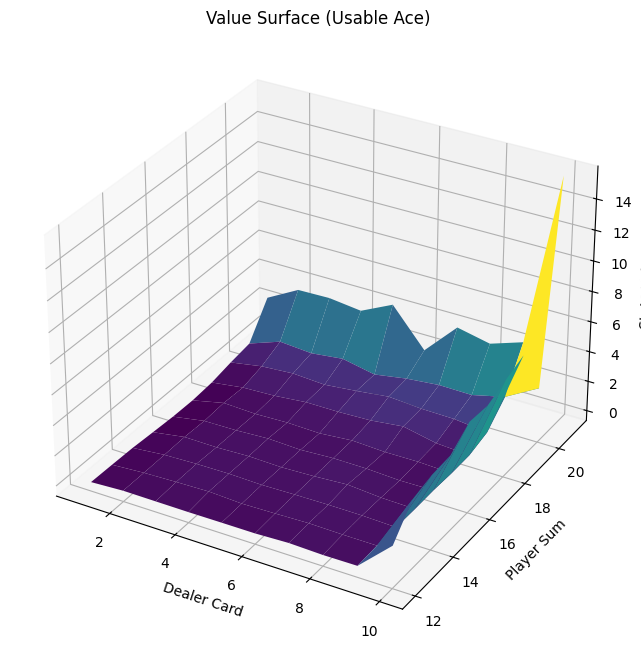

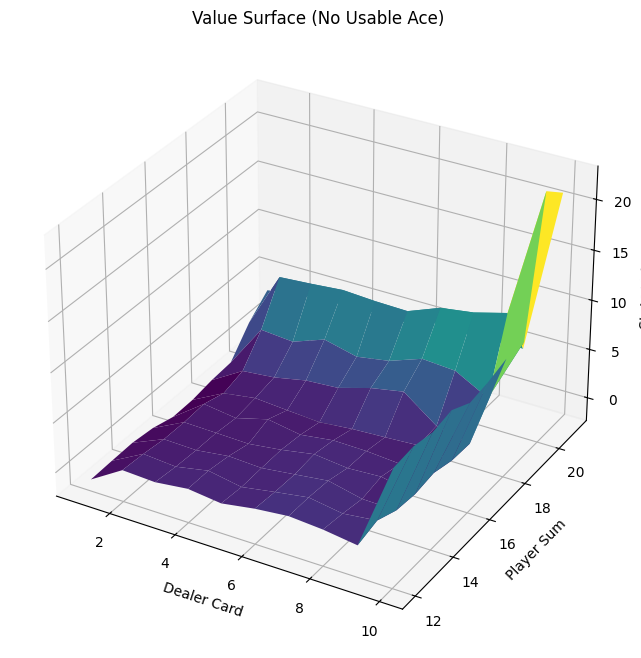

In [57]:
value_table = evaluate_policy(q_table, policy_table)

plot_value_surface(value_table, usable_ace=True)
plot_value_surface(value_table, usable_ace=False)

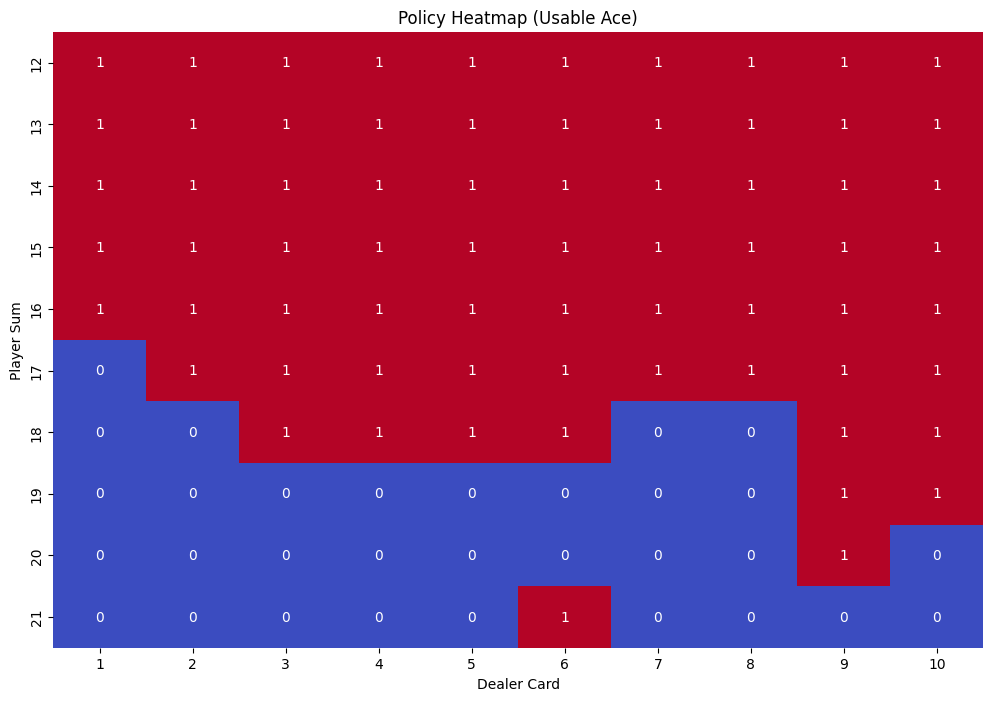

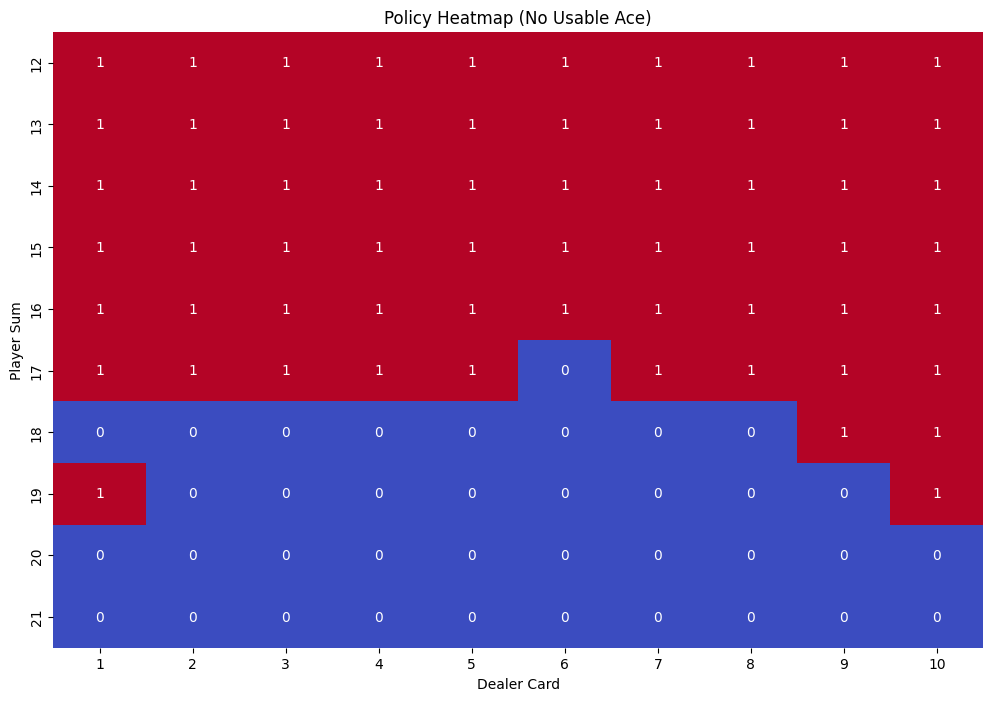

In [58]:
plot_policy_heatmap(policy_table, usable_ace=True)
plot_policy_heatmap(policy_table, usable_ace=False)

In [59]:
# Make the same procedure for different hyperparameters
# NOTE: Disable if it takes too long to run
for gamma in [0.5, 1.0]:
    for epsilon_decay in [0.99, 0.90]:
        for epsilon_min in [0.01, 0.1]:
            for epsilon_start in [1.0, 0.1]:
                q_table, policy_table = sarsa(
                    env,
                    num_episodes=100000,
                    gamma=gamma,
                    epsilon_decay=epsilon_decay,
                    epsilon_min=epsilon_min,
                    epsilon_start=epsilon_start,
                )

                value_table = evaluate_policy(q_table, policy_table)

                plot_value_surface(value_table, usable_ace=True)
                plot_value_surface(value_table, usable_ace=False)

                plot_policy_heatmap(policy_table, usable_ace=True)
                plot_policy_heatmap(policy_table, usable_ace=False)

Output hidden; open in https://colab.research.google.com to view.

# Task 7: Analysis of results

Briefly answer the questions below.

1. Is SARSA on-policy or off-policy? Why?

Answer:
Because SARSA uses the action selected by the agent's current policy to update the Q-values, it is on-policy. The learning process becomes reliant on the policy being adhered to as the update rule takes into account the agent's real subsequent action during exploration. As opposed to Q-learning, which learns the best policy, SARSA learns the Q-values for the particular policy being implemented. SARSA is on-policy because it directly learns from the actions taken by the current policy, incorporating the exploration behavior into its learning updates.

2. Experiment with different values of $\gamma, \epsilon_{start}, \epsilon_{min}$, $\epsilon$ decay factor (you should also try a decay of 1, which corresponds to vanilla $\epsilon$-greedy with $\epsilon=\epsilon_{start}$). How do these hyperparameters affect your results?

Answer:
Discount Factor (𝛾) controls the importance of future rewards compared to immediate rewards.

When 𝛾 is low, such as 0.5, the agent focuses on short-term rewards. This can lead to faster convergence but may result in suboptimal long-term strategies.
When 𝛾 is high, such as 0.9 or 0.99, the agent values future rewards more. This encourages the agent to consider long-term benefits but may increase the time needed to converge.
When 𝛾 equals 1, the agent considers future rewards indefinitely. This can lead to instability if the environment does not have episode termination.
In general, a higher 𝛾 is suitable for environments where rewards are delayed.

Initial Exploration Rate (ϵ start) defines the probability of taking random actions at the beginning of training.

A high ϵ start, such as 0.9, encourages the agent to explore extensively at the start, which is beneficial in complex environments where the optimal policy is unknown.
A low ϵ start, such as 0.1, means the agent explores less and exploits known actions more. This may lead to faster convergence but increases the risk of getting stuck in suboptimal policies.
Starting with a high ϵ start and decaying it over time helps balance exploration and exploitation.

Minimum Exploration Rate (ϵ min) sets a lower bound on the exploration rate after decay.

A low ϵ min, such as 0.01, ensures that the agent continues to explore occasionally even in the later stages of training. This can prevent the agent from becoming too rigid in its learned policy.
A higher ϵ min, such as 0.1, maintains a higher level of exploration throughout training, which can help avoid convergence to local optima but might reduce efficiency.
A small ϵ min is typically preferred for maintaining minimal exploration.

Decay Factor ϵ controls how quickly the exploration rate ϵ decreases over time.

If the decay factor is close to 1, such as 0.99, ϵ decreases slowly, maintaining exploration for a longer period. This approach is useful for environments with large state spaces.
If the decay factor is lower, such as 0.9, ϵ decreases quickly, leading to early exploitation. This works well in simpler environments.
If the decay factor is 1, there is no decay, and ϵ remains constant at ϵ start. This corresponds to a vanilla ϵ-greedy approach where exploration is constant.
Choosing the right decay factor depends on the complexity of the environment. Slower decay helps in more complex settings.